In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree

In [4]:
covid_df = pd.read_csv('owid_covid_data.csv')

# Removing columns 
high_missing_cols = covid_df.columns[covid_df.isnull().mean() > 0.90]
medium_missing_cols = covid_df.columns[(covid_df.isnull().mean() > 0.50) & (covid_df.isnull().mean() <= 0.90)]

covid_df_clean = covid_df.drop(columns=high_missing_cols).drop(columns=medium_missing_cols)


covid_df_clean['case_fatality_rate'] = covid_df_clean['total_deaths'] / covid_df_clean['total_cases']
covid_df_clean['log_total_cases'] = np.log1p(covid_df_clean['total_cases'])
covid_df_clean['log_total_deaths'] = np.log1p(covid_df_clean['total_deaths'])

### Classification
---

#### Create a Response Variable

In [5]:
covid_df_clean = covid_df_clean[covid_df_clean['case_fatality_rate'].notnull()]  # remove rows with missing CFR

covid_df_clean['pandemic_response_score'] = pd.qcut(
    covid_df_clean['case_fatality_rate'], 
    q=3, 
    labels=["Good", "Moderate", "Poor"]
)


c:\Users\antho\OneDrive\Documents\COLLEGE\UH\4-Semester-4\COSC-3337\datascience-covid-project\3337-covid-report\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


#### Data Splitting

In [40]:
X = covid_df_clean.drop(columns=['pandemic_response_score', 'iso_code', 'location', 'date', 'continent', 'total_cases', 'total_deaths', 'case_fatality_rate'])
y = covid_df_clean['pandemic_response_score']


X = X.dropna()
y = y.loc[X.index]

# Identify rows with infinity values
inf_rows = np.isinf(X).any(axis=1)

# Remove rows with infinity values
X = X[~inf_rows]
y = y[~inf_rows]

# Verify that rows with infinity are removed
np.isinf(X).sum()

X_tr, X_tst, y_tr, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)



scaler = StandardScaler()
X_tr_norm = scaler.fit_transform(X_tr)
X_tst_norm = scaler.transform(X_tst) 

#### Decision Trees

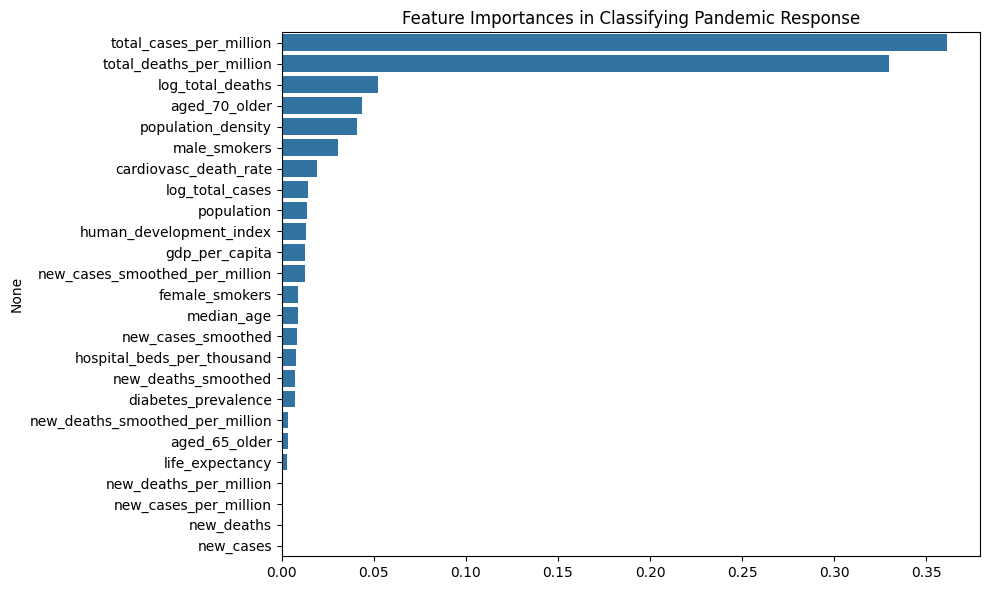

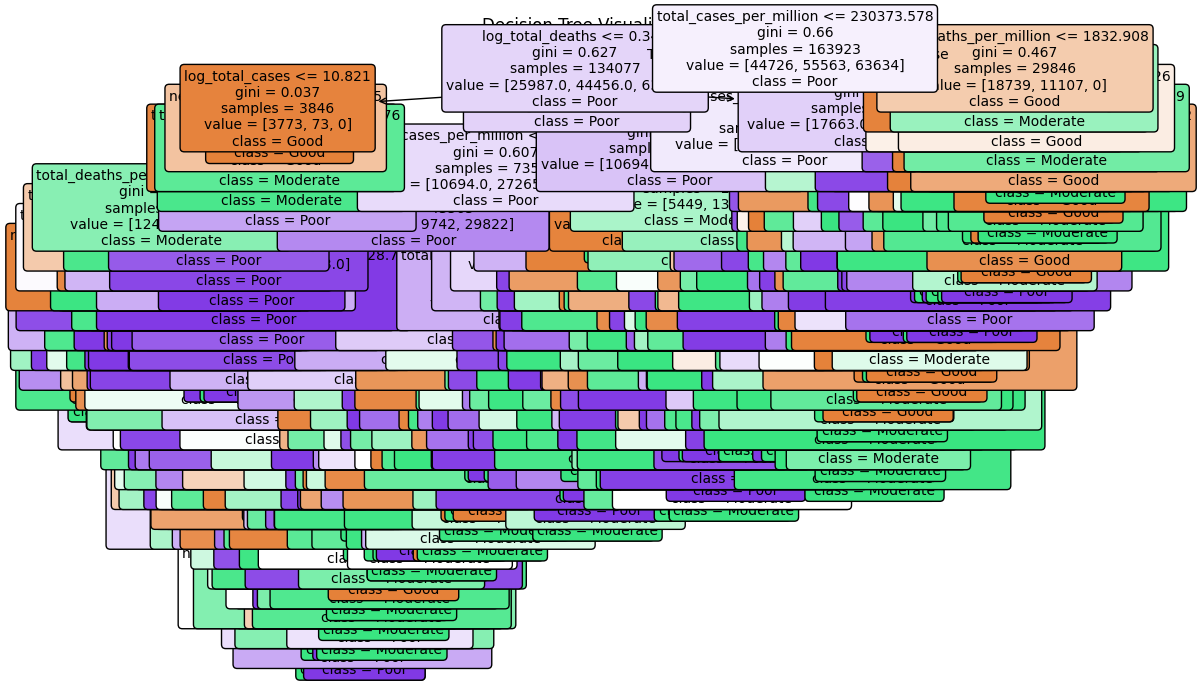

In [ ]:

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_tr, y_tr)  # No need to scale for Decision Trees
y_pred_dt = dt_model.predict(X_tst)

features = X.columns

importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Feature Importances in Classifying Pandemic Response")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plot_tree(dt_model, 
          feature_names=X.columns,  # feature names (column names)
          class_names=["Good", "Moderate", "Poor"],   # target class names
          filled=True,               # color the nodes based on class
          rounded=True,              # rounded corners for the nodes
          fontsize=10)               # adjust font size for readability
plt.title("Decision Tree Visualization")
plt.show()



##### Find Optimal Depth

In [ ]:
max_depths = [3, 5, 10, 30, 50]
kf = StratifiedKFold(n_splits=5)

for depth in max_depths:
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_tr, y_tr)  # No need to scale for Decision Trees
    y_pred_dt = dt_model.predict(X_tst)

#### KNN

In [41]:

knn_model = KNeighborsClassifier()
knn_model.fit(X_tr_norm, y_tr)  # Use scaled data for KNN
y_pred_knn = knn_model.predict(X_tst_norm)

#### SVM

In [16]:


svm_model = SVC(random_state=42)
svm_model.fit(X_tr_norm, y_tr)  # Use scaled data for SVM
y_pred_svm = svm_model.predict(X_tst_norm)

### Compare Models
---

#### Decision Tree

In [36]:
# Evaluate Decision Tree Model
print("Decision Tree Accuracy:", accuracy_score(y_tst, y_pred_dt))
print(classification_report(y_tst, y_pred_dt))
print(confusion_matrix(y_tst, y_pred_dt))



Decision Tree Accuracy: 0.9999755984480613
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00     11064
    Moderate       1.00      1.00      1.00     14078
        Poor       1.00      1.00      1.00     15839

    accuracy                           1.00     40981
   macro avg       1.00      1.00      1.00     40981
weighted avg       1.00      1.00      1.00     40981

[[11064     0     0]
 [    1 14077     0]
 [    0     0 15839]]


#### KNN 

In [42]:
# Evaluate KNN Model
print("KNN Accuracy:", accuracy_score(y_tst, y_pred_knn))
print(classification_report(y_tst, y_pred_knn))
print(confusion_matrix(y_tst, y_pred_knn))


KNN Accuracy: 0.9949732803006271
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00     11064
    Moderate       0.99      0.99      0.99     14078
        Poor       1.00      1.00      1.00     15839

    accuracy                           0.99     40981
   macro avg       1.00      0.99      0.99     40981
weighted avg       0.99      0.99      0.99     40981

[[11014    48     2]
 [   37 13972    69]
 [    4    46 15789]]


#### SVM

In [21]:
# Evaluate SVM Model
print("SVM Accuracy:", accuracy_score(y_tst, y_pred_svm))
print(classification_report(y_tst, y_pred_svm))
print(confusion_matrix(y_tst, y_pred_svm))


SVM Accuracy: 0.9690802157307759
              precision    recall  f1-score   support

        Good       0.98      0.96      0.97     11080
    Moderate       0.94      0.97      0.96     14043
        Poor       0.99      0.97      0.98     15854

    accuracy                           0.97     40977
   macro avg       0.97      0.97      0.97     40977
weighted avg       0.97      0.97      0.97     40977

[[10672   407     1]
 [  201 13609   233]
 [   13   412 15429]]


### Evaluation
---

#### 10 Fold Cross Validation

In [22]:
from sklearn.model_selection import cross_val_score

# Cross-validation for Decision Tree
dt_cv_score = cross_val_score(dt_model, X, y, cv=10)
print(f"Decision Tree Cross-Validation Score: {dt_cv_score.mean()}")

# # Cross-validation for KNN
# knn_cv_score = cross_val_score(knn_model, X_scaled, y, cv=10)
# print(f"KNN Cross-Validation Score: {knn_cv_score.mean()}")

# # Cross-validation for SVM
# svm_cv_score = cross_val_score(svm_model, X_scaled, y, cv=)
# print(f"SVM Cross-Validation Score: {svm_cv_score.mean()}")


Decision Tree Cross-Validation Score: 0.9998291682936353
